<div align='center'><font size="5" color='#353B47'>Handwritten Letters Classification</font></div>
<div align='center'><font size="4" color="#353B47">With Convolutional Neural Networks</font></div>
<br>
<hr>

## <div id="summary">Table of contents</div>

**<font size="2"><a href="#chap1">1. Setup</a></font>**
**<br><font size="2"><a href="#chap2">2. Preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. A CNN Model for Handwritten Letters Classification</a></font>**
**<br><font size="2"><a href="#chap4">4. Evaluation</a></font>**
**<br><font size="2"><a href="#chap5">5. Going further, A model for background recognition</a></font>**

# <div id="chap1">1. Setup</div>

## <font color='blue'>1.1 Dependancies</font>

In [1]:
# Remove warning messages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

# navigation and read files
import glob
import os

# Read HDF5 binary data format: convenient for large data storage
import h5py

# Read and display images
import matplotlib.pyplot as plt
import imageio
import cv2
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
#from tensorflow import keras

# DL dependancies
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, LeakyReLU,GlobalMaxPooling2D
from tensorflow.keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

## <font color='blue'>1.2 Import Data</font>

In [2]:
# Path of images
PATH_TO_DATA = '../input/classification-of-handwritten-letters/'
CSV_FILES =  ['letters.csv', 'letters2.csv', 'letters3.csv']

In [3]:
def import_data(CSV_FILE):
    data = pd.read_csv(PATH_TO_DATA + CSV_FILE)
    # Create path extention for corresponding folders that contains images 
    data['source'] = CSV_FILE[:-4]+'/'
    return data

## <font color='blue'>1.3 Concatenate Data</font>

In [4]:
data1 = import_data(CSV_FILES[0])
data2 = import_data(CSV_FILES[1])
data3 = import_data(CSV_FILES[2])
data = pd.concat([data1, data2, data3], ignore_index=True)

# I won't use these data anymore
del(data1, data2, data3)

## <font color='blue'>1.4 Shuffle data</font>

In [5]:
# Shuffle data
data = shuffle(data, random_state = 42)

**<font size="2"><a href="#summary">Back to summary</a></font>**

-------

# <div id="chap2">2. Preprocessing</div>

## <font color='blue'>2.1 One hot encoding</font>

In [6]:
data.head()

,letter,label,file,background,source
6491,щ,27,27_212.png,2,letters2/
2012,в,3,03_53.png,2,letters2/
13295,ы,29,29_336.png,3,letters3/
11270,с,19,19_311.png,3,letters3/
12837,щ,27,27_278.png,3,letters3/


<div align="justify"><font size="3">For each row, we get the letter, its index in letters vector, the handwritten letter as .png file, the background of the paper the letter was written and the source. The goal of the preprocessing step is to encode the background and the letter column.</font></div>

In [7]:
# Get all labels in one string
letters = '' 
for letter in data.letter.unique():
    letters += letter
    
# Which letter is written on each image
labels = data.label

Meaning of background categories

* striped = 0
* gridded = 1
* no background = 2
* graph paper = 3

In [8]:
def ohe_letters(label):
    '''
    One hot encoding for the target label
    '''
    resu = np.zeros(len(letters))
    index = letters.index(label)
    resu[index] = 1
    return resu

def ohe_backgrounds(label):
    '''
    One hot encoding for background column
    '''
    resu = np.zeros(len(data.background.unique()))
    resu[label] = 1
    return resu

In [9]:
data['encoded_letter'] = data['letter'].apply(lambda x:ohe_letters(x))
data['encoded_background'] = data['background'].apply(lambda x:ohe_backgrounds(x))

In [10]:
data.head()

,letter,label,file,background,source,encoded_letter,encoded_background
6491,щ,27,27_212.png,2,letters2/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
2012,в,3,03_53.png,2,letters2/,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0]"
13295,ы,29,29_336.png,3,letters3/,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
11270,с,19,19_311.png,3,letters3/,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"
12837,щ,27,27_278.png,3,letters3/,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0]"


<div align="justify"><font size="3">The data has the correct format, we can now extract the information we need to train a model.</font></div>

## <font color='blue'>2.2 Reshape, Filter and Normalize</font>

In [11]:
# Store all png images into one numpy array
images = []
# Will be the target
encoded_labels = []

backgrounds = []
encoded_backgrounds = []

# I want to be sure that every image is consitent
for i, row in data.iterrows():
    img_name = row['file']
    numpy_image = cv2.imread(os.path.join(PATH_TO_DATA + row['source'], img_name))
    if numpy_image.shape == (32, 32, 3):
        images.append(numpy_image)
        encoded_labels.append(row['encoded_letter'])
        backgrounds.append(row['background'])
        encoded_backgrounds.append(row['encoded_background'])
        
# Normalize array of images
images = np.array(images)/255

## <font color='blue'>2.3 Display letters</font>

In [12]:
def display_image(images_list, list_of_labels = np.arange(9)):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index in list_of_labels:
        
        # Get corresponding label
        ohe_label = encoded_labels[index]
        index_letter = list(ohe_label).index(1)
        associated_letter = letters[index_letter]

        # Get background
        associated_background = backgrounds[index]
        
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Label: %s \n'%associated_letter+\
                 'Background: %s\n'%associated_background,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(images[index])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

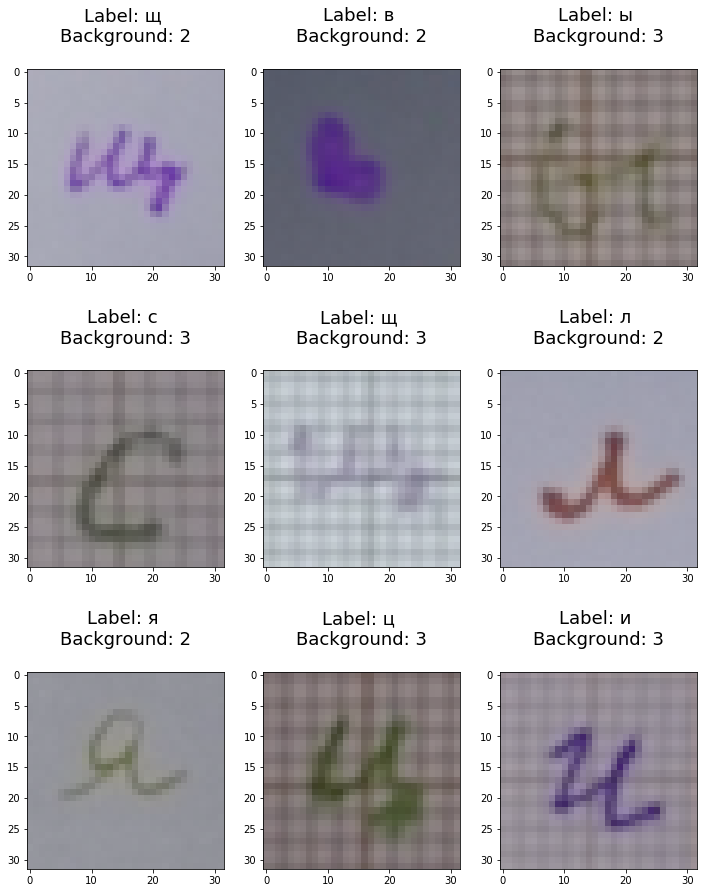

In [13]:
display_image(images)

## <font color='blue'>2.4 Prepare Train and Validation set</font>

In [14]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_labels.copy())

# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

<div align="justify"><font size="3">We're all set and the data are ready to feed the model. Let's create the model now.</font></div>

**<font size="2"><a href="#summary">Back to summary</a></font>**

------

# <div id="chap3">3. A CNN Model for Handwritten Letters Classification</div>

## <font color='blue'>3.1 What is a CNN ?</font>

<div align="justify"><font size="3">A CNN is quite similar to Classic Neural Networks (RegularNets) where there are neurons with weights and biases. Just like in RegularNets, we use a loss function and an optimizer in CNNs. Additionally though, in CNNs, there are Convolutional Layers, Pooling Layers, and Flatten Layers. CNNs are mainly used for image classification.

### <font color="orange">CNN layers

* **Convolutional layer** 

> <div align="justify"><font size="3">The very first layer where we extract features from the images in our datasets. Due to the fact that pixels are only related with the adjacent and close pixels, convolution allows us to preserve the relationship between different parts of an image. Convolution is basically filtering the image with a smaller pixel filter to decrease the size of the image without loosing the relationship between pixels. When we apply convolution to 5x5 image by using a 3x3 filter with 1x1 stride (1 pixel shift at each step). We will end up having a 3x3 output (64% decrease in complexity).</font></div>

* **Pooling layer**

> <div align="justify"><font size="3">When constructing CNNs, it is common to insert pooling layers after each convolution layer to reduce the spatial size of the representation to reduce the parameter counts which reduces the computational complexity. In addition, pooling layers also <b>helps with the overfitting problem</b>. Basically we select a pooling size to reduce the amount of the parameters by selecting the maximum, average, or sum values inside these pixels.</font></div>

* **Flatten layer**

> <div align="justify"><font size="3">Flattens the input. Does not affect the batch size.</font></div>

## <font color='blue'>3.2 Parameters</font>

In [15]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(letters)
# Group of training samples
BATCH_SIZE = 64
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

## <font color='blue'>3.3 Good reflexes to have</font>

* **Add dropout**

> <div align="justify"><font size="3">Dropout refers to ignoring neurons during the training phase of certain set of neurons which is chosen at random.

* **LeakyRelu**

> <div align="justify"><font size="3">The advantage of using Leaky ReLU instead of ReLU is that in this way we cannot have vanishing gradient. Parametric ReLU has the same advantage with the only difference that the slope of the output for negative inputs is a learnable parameter while in the Leaky ReLU it's a hyperparameter.

* **Add callbacks**

> <div align="justify"><font size="3">A callback is a function that is to be executed after another function has finished executing hence the name 'call back'. With callbacks, you can define earlystopping criterias for your model if it doesn't learn anymore through epochs. Callback allows you to store some information at the end of each epoch so you can check your model's performance.

## <font color='blue'>3.4 Define a custom metric</font>

In [16]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## <font color='blue'>3.5 Create model</font>

In [17]:
def CNN_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [18]:
# Init CNN model
cnn_model = CNN_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history = cnn_model.fit(X_train, y_train,
                        batch_size = BATCH_SIZE,
                        epochs = EPOCHS,
                        verbose = 1,
                        validation_data = (X_val, y_val),
                        callbacks = [checkpointer, lr_reduction, estopping])

Train on 11342 samples, validate on 2836 samples
Epoch 1/100
11264/11342 [============================>.] - ETA: 0s - loss: 3.4150 - accuracy: 0.0561 - top_3_categorical_accuracy: 0.1512
Epoch 00001: val_loss improved from inf to 3.00964, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 5s 483us/sample - loss: 3.4128 - accuracy: 0.0564 - top_3_categorical_accuracy: 0.1524 - val_loss: 3.0096 - val_accuracy: 0.1805 - val_top_3_categorical_accuracy: 0.3734
Epoch 2/100
11200/11342 [============================>.] - ETA: 0s - loss: 2.6733 - accuracy: 0.2434 - top_3_categorical_accuracy: 0.4644
Epoch 00002: val_loss improved from 3.00964 to 2.18382, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 2s 168us/sample - loss: 2.6669 - accuracy: 0.2450 - top_3_categorical_accuracy: 0.4660 - val_loss: 2.1838 - val_accuracy: 0.3967 - val_top_3_categorical_accuracy: 0.6195
Epoch 3/100
11136/11342 [========================

## <font color='blue'>3.6 Plot history errors</font>

In [19]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'top_3_categorical_accuracy', 'val_loss', 'val_accuracy', 'val_top_3_categorical_accuracy', 'lr'])


In [20]:
def plot_history(model_history):

    plt.figure(figsize = (20,15))
    
    plt.subplot(221)
    # summarize history for accuracy
    plt.plot(model_history.history['top_3_categorical_accuracy'])
    plt.plot(model_history.history['val_top_3_categorical_accuracy'])
    plt.title('top_3_categorical_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    plt.subplot(222)
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    plt.subplot(223)
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    
    plt.subplot(224)
    # summarize history for lr
    plt.plot(model_history.history['lr'])
    plt.title('learning rate')
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.grid()
    
    plt.show()

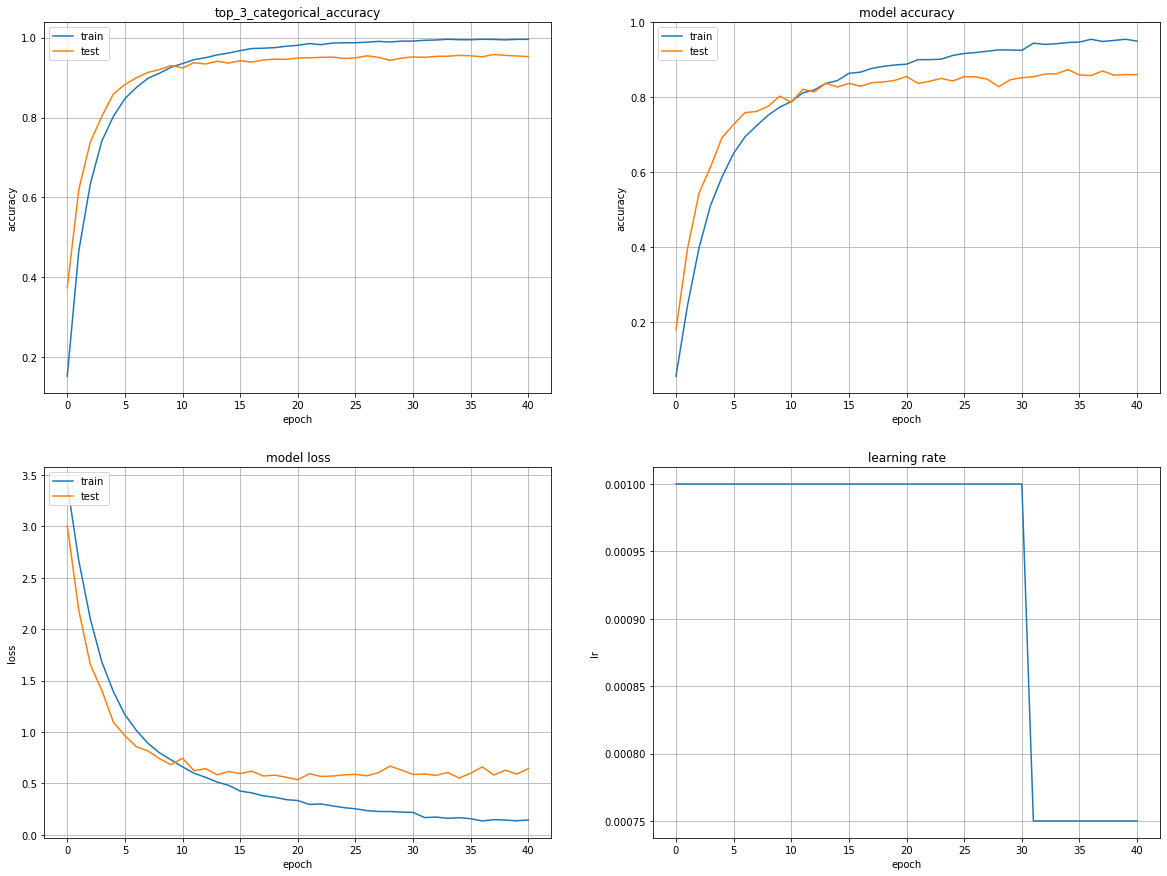

In [21]:
plot_history(history)

**<font size="2"><a href="#summary">Back to summary</a></font>**

------

# <div id="chap1">4. Evaluation</div>

In [22]:
# loading the model with the best validation accuracy
cnn_model.load_weights('weights.best.letters.hdf5')
cnn_model.evaluate(X_val, y_val)

2836/2836 [==============================] - 0s 131us/sample - loss: 0.5362 - accuracy: 0.8558 - top_3_categorical_accuracy: 0.9489


[0.5361829899430107, 0.8557828, 0.9488717]

## <font color='blue'>4.1 Load one prediction</font>

In [23]:
def load_image(path_filename):
	# load the image
	img = load_img(path_filename, target_size=(32, 32))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1, 32, 32, 3)
	# prepare pixel data
	img = img.astype('float32')
	img = img / 255.0
	return img

In [24]:
def get_true_label(path_filename, dataframe, column_to_get):
    filename = os.path.basename(os.path.normpath(path_filename))
    index_row = data[data['file']==filename].index[0]
    return data.loc[index_row, column_to_get]

In [25]:
img = load_image(PATH_TO_DATA+'letters3/01_235.png')

predicted: а
true label: а


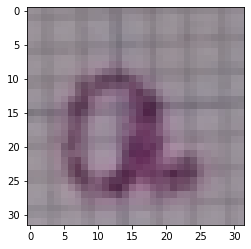

In [26]:
# predict the class
a_letter = cnn_model.predict_classes(img)

plt.imshow(img[0])
print('predicted:', letters[a_letter[0]])
print('true label:', get_true_label(PATH_TO_DATA+'letters3/01_235.png', data, 'letter'))

## <font color='blue'>4.2 Load multiple predictions</font>

In [27]:
def load_random_images(number_of_images_to_load = 9):
    images = []
    true_labels = []
    true_backgrounds = []
    
    which_folder = [random.randint(1,3) for _ in range(number_of_images_to_load)]
    for index_folder in which_folder:
        if index_folder == 1:
            path = PATH_TO_DATA+'letters/'
        else:
            path = PATH_TO_DATA+'letters'+str(index_folder)+'/'
        nb_files = len(os.listdir(path))
        
        index_image = random.randint(0, len(os.listdir(path)))
        
        image = load_image(path + os.listdir(path)[index_image])
        label = get_true_label(path + os.listdir(path)[index_image], data, 'letter')
        background = get_true_label(path + os.listdir(path)[index_image], data, 'background')

        images.append(image)
        true_labels.append(label)
        true_backgrounds.append(background)
        
    return images, true_labels, true_backgrounds

In [28]:
def classes_predictions(images_list_to_classify, true_labels, model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = model.predict_classes(image)
        associated_letter = letters[a_letter[0]]
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

In [29]:
test_images, true_labels, true_backgrounds = load_random_images()

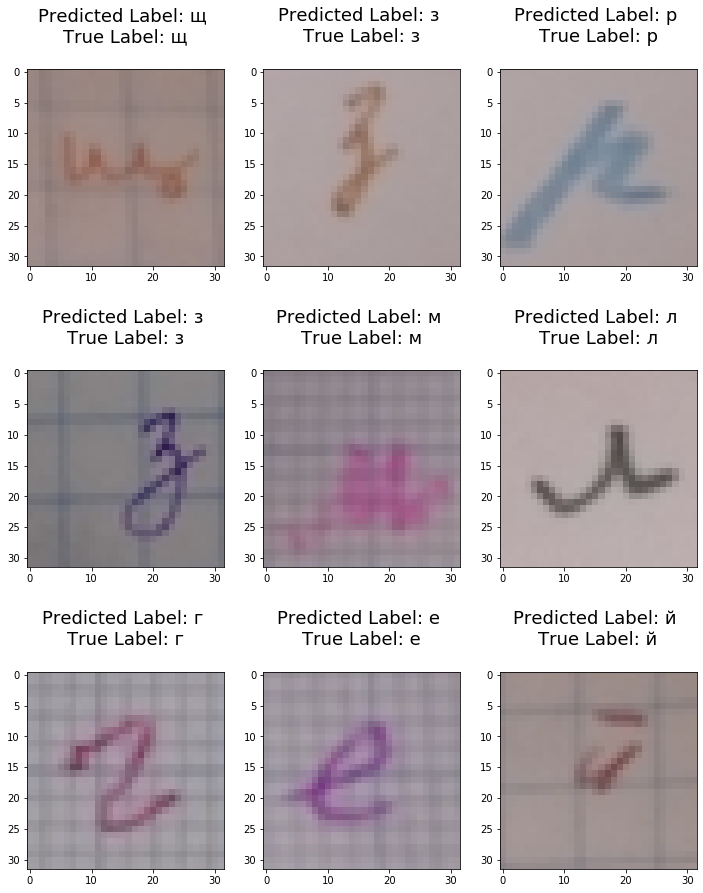

In [30]:
classes_predictions(test_images, true_labels, cnn_model)

**<font size="2"><a href="#summary">Back to summary</a></font>**

-------

# <div id="chap5">5. Going further, A model for background recognition</div>

## <font color='blue'>5.1 Setup</font>

In [31]:
# Define X_data and target
X = np.array(images.copy())
y = np.array(encoded_backgrounds.copy())

In [32]:
# Stratified train_test split on labels
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=.2, 
                                                  stratify = y, 
                                                  random_state=42)

In [33]:
# Define image dimensions
IMG_ROWS = 32
IMG_COLS = 32
# 3 stands for RGB images, 1 if greyscaled images
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)

# Number of classes to consider
NUM_CLASSES = len(set(backgrounds))
# Group of training samples
BATCH_SIZE = 32
# Number of complete presentations of the dataset to be learned
EPOCHS = 100

In [34]:
def CNN_back_model(activation = 'softmax', 
              loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy', top_3_categorical_accuracy]):
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu',
                     input_shape = INPUT_SHAPE))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(Conv2D(128, (4, 4), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(NUM_CLASSES, activation = activation))
    
    # Compile the model
    model.compile(loss = loss,
                  optimizer = optimizer, 
                  metrics = metrics)
    
    return model

In [35]:
# Init CNN model
background_model = CNN_back_model()

# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights.best.letters.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

# Reduce learning rate when a metric has stopped improving
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=10, 
                                 verbose=2, 
                                 factor=.75)

# If score doesn't improve during patience=20 epochs, stop learning
estopping = EarlyStopping(monitor='val_loss', 
                          patience=20, 
                          verbose=2)

# Training
history_background = background_model.fit(X_train, y_train,
                                          batch_size = BATCH_SIZE,
                                          epochs = EPOCHS,
                                          verbose = 1,
                                          validation_data = (X_val, y_val),
                                          callbacks = [checkpointer, lr_reduction, estopping])

Train on 11342 samples, validate on 2836 samples
Epoch 1/100
11136/11342 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.7519 - top_3_categorical_accuracy: 0.9601
Epoch 00001: val_loss improved from inf to 0.29716, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 4s 331us/sample - loss: 0.6610 - accuracy: 0.7545 - top_3_categorical_accuracy: 0.9603 - val_loss: 0.2972 - val_accuracy: 0.8917 - val_top_3_categorical_accuracy: 0.9824
Epoch 2/100
11328/11342 [============================>.] - ETA: 0s - loss: 0.2441 - accuracy: 0.9101 - top_3_categorical_accuracy: 0.9884
Epoch 00002: val_loss improved from 0.29716 to 0.18175, saving model to weights.best.letters.hdf5
11342/11342 [==============================] - 3s 242us/sample - loss: 0.2441 - accuracy: 0.9102 - top_3_categorical_accuracy: 0.9884 - val_loss: 0.1818 - val_accuracy: 0.9365 - val_top_3_categorical_accuracy: 0.9933
Epoch 3/100
11264/11342 [========================

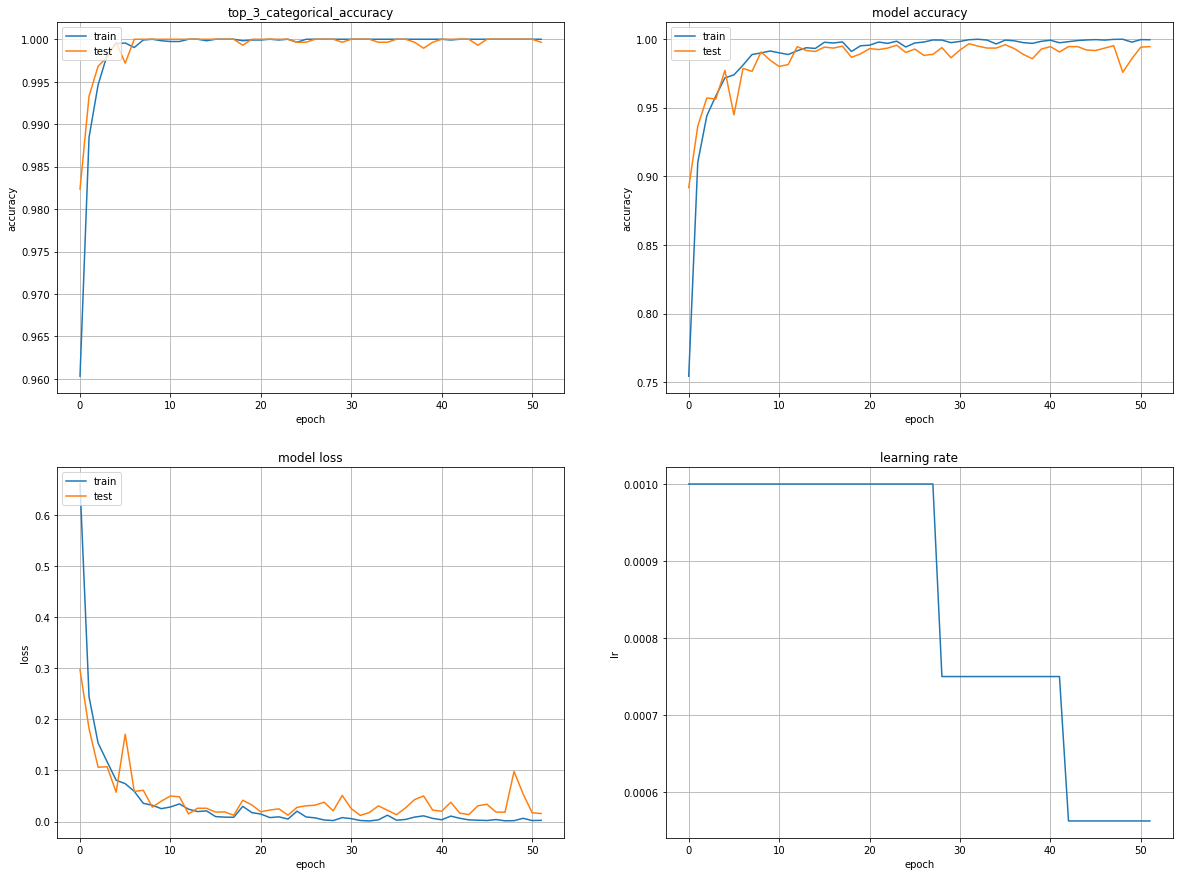

In [36]:
plot_history(history_background)

## <font color='blue'>5.2 Evaluation & prediction plots</font>

In [37]:
# loading the model with the best validation accuracy
background_model.load_weights('weights.best.letters.hdf5')
background_model.evaluate(X_val, y_val)

2836/2836 [==============================] - 0s 148us/sample - loss: 0.0119 - accuracy: 0.9965 - top_3_categorical_accuracy: 1.0000


[0.011943034089112592, 0.9964739, 1.0]

In [38]:
def improved_classes_predictions(images_list_to_classify, true_labels, true_backgrounds, letter_model, backg_model):
    
    # plot first few images
    plt.figure(figsize=(12,12))
    for index, image in enumerate(images_list_to_classify):
        
        a_letter = letter_model.predict_classes(image)
        associated_letter = letters[a_letter[0]]
        
        a_background_letter = background_model.predict_classes(image) 
        
        # define subplot
        plt.subplot(330 + 1 + index)
        plt.title('Predicted Label: %s \n'%associated_letter+\
                  'True Label: %s\n'%true_labels[index]+\
                  'Predicted Background: %s\n'%a_background_letter[0]+\
                  'True Background: %s\n'%true_backgrounds[index],
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(image[0])
        
    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
        
    # show the figure
    plt.show()

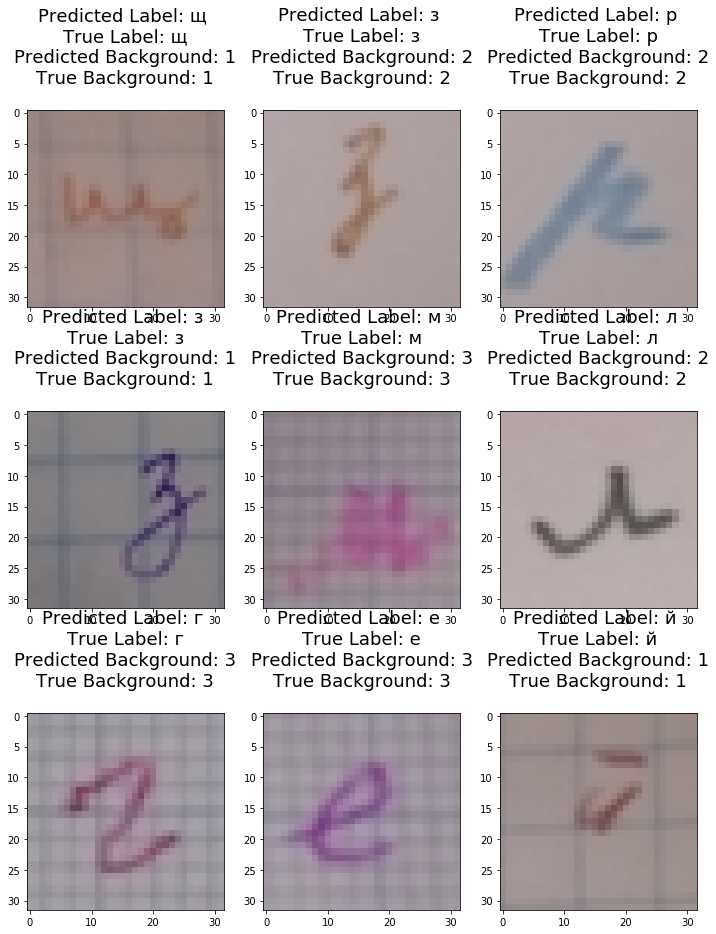

In [39]:
improved_classes_predictions(test_images, true_labels, true_backgrounds, cnn_model , background_model)

**<font size="2"><a href="#summary">Back to summary</a></font>**

------

# References

* Many thanks to <a href="https://www.kaggle.com/olgabelitskaya">Olga Belitskaya</a> for the huge work on the <a href="https://www.kaggle.com/olgabelitskaya/classification-of-handwritten-letters">data</a>
* Insightful <a href="https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d">article</a> on MNIST classification with CNN
* Explanation of <a href="https://computersciencewiki.org/index.php/Max-pooling_/_Pooling">MaxPooling</a>
* The <a href="https://towardsdatascience.com/the-vanishing-gradient-problem-69bf08b15484">vanishing gradient</a> problem

<hr>
<br>
<div align='justify'><font color="#353B47" size="4">Thank you for taking the time to read this notebook. I hope that I was able to answer your questions or your curiosity and that it was quite understandable. <u>any constructive comments are welcome</u>. They help me progress and motivate me to share better quality content. I am above all a passionate person who tries to advance my knowledge but also that of others. If you liked it, feel free to <u>upvote and share my work.</u> </font></div>
<br>
<div align='center'><font color="#353B47" size="3">Thank you and may passion guide you.</font></div>